# **Rock-Paper-Scissor Competition (40%)**
For this competition, we will use the Game (https://cloudstor.aarnet.edu.au/plus/s/6QNijohkrfMZ0H7) dataset. This dataset contains images of hand gestures from the Rock-Paper-Scissors game. 

The dataset contains a total of 2188 images corresponding to the 'Rock' (726 images), 'Paper' (710 images) and 'Scissors' (752 images) hand gestures of the Rock-Paper-Scissors game. All image are taken on a green background with relatively consistent ligithing and white balance.

All images are RGB images of 300 pixels wide by 200 pixels high in .png format. The images are separated in three sub-folders named 'rock', 'paper' and 'scissors' according to their respective class.

The task is to categorize each hand guesters into one of three categories (Rock/Paper/Scissor). 

We provide a baseline by the following steps:


*   Loding and Analysing the dataset using torchvision.
*   Defining a simple convolutional neural network. 
*   How to use existing loss function for the model learning. 
*   Train the network on the training data. 
*   Test the trained network on the testing data. 

The following trick/tweak(s) could be considered:
-------
1. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, Number of Max Epochs, and Drop-out. 
2. Use of a new loss function.
3. Data augmentation
4. Architectural Changes: Batch Normalization, Residual layers, Attention Block, and other varients.

Your code should be modified from the provided baseline. A pdf report is required to explain the tricks you employed, and the imporvements they achieved.
Marking Rules:
-------
We will mark the competition based on the final test accuracy on testing images and your report.

Final mark = acc_mark + efficiency mark + report mark + bonus mark
###Acc_mark 15:

We will rank all the submission results based on their test accuracy. The top 30% of the students will get full marks.


|Accuracy|Mark|
|---|---|
| Top 30% in the class|          15|
|30%-50%|         11|
|50%-80%  |        7|
| 80%-90%  |      3|
| 90%-100%  |      1|
|Not implemented| 0|

###Efficiency mark 5:

Efficiency is evaluated by the computational costs (flops: https://en.wikipedia.org/wiki/FLOPS). Please report the computational costs for your final model and attach the code/process about how you calculate it.

|Efficiency|Mark|
|---|---|
| Top 30% in the class|          5|
|30%-50%|         4|
|50%-80%  |        3|
| 80%-90%  |      2|
| 90%-100%  |      2|
|Not implemented| 0|

###Report mark 20:
1. Introduction and your understanding to the baseline model: 2 points

2. Employed more than three tricks with ablation studies to improve the accuracy: 6 points

Clearly explain the reference, motivation and design choice for each trick/tweak(s). Providing the experimental results in tables.
Example table:

|Trick1|Trick2|Trick3|Accuracy|
|---|---|---|---|
|N|N|N|60%|
|Y|N|N|65%|
|Y|Y|N|77%|
|Y|Y|Y|82%|

Observation and discussion based on the experiment results.

3. Expaination of the methods on reducing the computational cost and/or improve the trade-off between accuracy and efficiency: 4 points

4. Explaination of the code implementation：3 points

5. Visulization results: e.g. training and testing accuracy/loss for each model, case studies: 3 points

6. Open ended:  Limitations, conclusions, failure cases analysis...: 2 points

###Bouns mark:
1. Top three results: 2 points
2. Fancy designs: 2 points

In [1]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [2]:
##################################################################################################################################
### Subject: Computer Vision 
### Year: 2022
### Student Name: Shota Kuramoto, Vanessa Sy
### Student ID: a1769191, a1725646
### Comptetion Name: Rock-Paper-Scissor Classification Competition
### Final Results:
### ACC: 99.14%        FLOPs:1.14G
##################################################################################################################################

In [3]:
# Importing libraries. 

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Mounting G-Drive to get your dataset. 
# To access Google Colab GPU; Go To: Edit >>> Network Settings >>> Hardware Accelarator: Select GPU. 
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971 
from google.colab import drive
drive.mount('/content/drive')

# Dataset path.
#data_dir = '/content/drive/MyDrive/CV_Competition/rps-cv-images/rps_data'
data_dir = '/content/drive/MyDrive/CV_Competition/rps-cv-images'
classes = os.listdir(data_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from torchvision.transforms.functional import autocontrast
from torchvision.transforms.transforms import RandomHorizontalFlip
#PERSONALISED DATA AUGMENTAIOTN
 
my_train_transform=transforms.Compose([
        transforms.Resize(40),
        transforms.CenterCrop(40),       

        #data augmentation technique that achieved highest accuracy, comment this out to test the model with augmentation.
        #transforms.RandomGrayscale(p=0.5),
        
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomVerticalFlip(p=0.25),
        #transforms.RandomPerspective(0.5,p=0.5),
        #transforms.RandomAutocontrast(p=0.5),
        #transforms.RandomAdjustSharpness(5.5,p=0.25),
        #transforms.GaussianBlur(kernel_size=3,sigma=(0.1,2.0)),
        
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [6]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=my_train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 2188


In [7]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 40, 40])


In [8]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  paper (0)


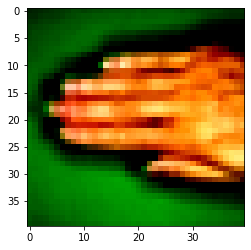

In [9]:
show_image(*dataset[200])

In [10]:
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//10
test_size = len(dataset)//5
train_size = len(dataset) - val_size - test_size

In [11]:
# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)  

(1533, 218, 437)

In [12]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


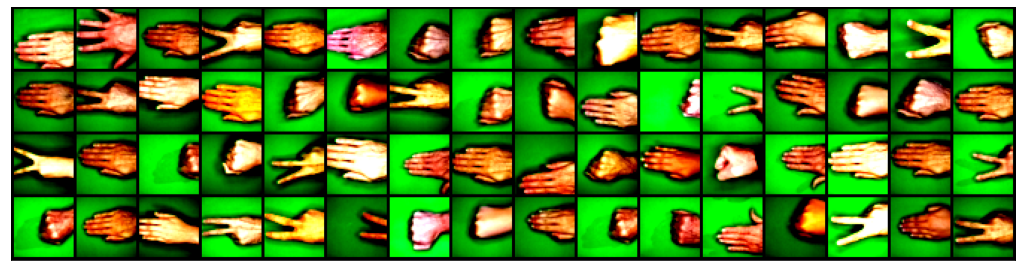

In [13]:
# Multiple images preview. 
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [14]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [15]:
# Functions for evaluation and training.
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
# To check wether Google Colab GPU has been assigned/not. 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [18]:
input_size = 3*40*40
output_size = 3

In [19]:
# Model - 7 Layer
class CnnModel(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 
            nn.Linear(6250, 64),  
            nn.Tanh(),         
            nn.Linear(64, 32),  
            nn.Tanh(),       
            nn.Linear(32, 16),           
            nn.Tanh(),
            nn.Linear(16, 8),
            nn.Tanh(),
            nn.Dropout(0.25),
            nn.Linear(8, self.classes))
        
    def forward(self, xb):
        return self.network(xb)

In [20]:
# Model print
num_classes = 3
model = CnnModel(num_classes)
model.cuda()

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Tanh()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Tanh()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Tanh()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Tanh()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Tanh()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=6250, out_features=64, bias=True)
    (17): Tanh()
    (18): Linear(in_features=

In [21]:
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 40, 40])
out.shape: torch.Size([64, 3])
out[0]: tensor([-0.0461, -0.0061,  0.2111], device='cuda:0', grad_fn=<SelectBackward0>)


In [22]:
def dataloader(train_loader, val_loader, model):
  train_dl = DeviceDataLoader(train_loader, device)
  val_dl = DeviceDataLoader(val_loader, device)
  model = to_device(model, device)
  
  return train_dl, val_dl, model

In [23]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
#model = to_device(CnnModel(), device)  #ORIGINAL CODE GIVEN - GIVES ERROR
model = to_device(CnnModel(3), device)  

In [25]:
history=[evaluate(model, val_loader)]
history

[{'val_acc': 0.3317708373069763, 'val_loss': 1.131535530090332}]

In [26]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0011 #[0.001,0.003,0.005,0.1]

In [27]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.9311, val_loss: 0.7491, val_acc: 0.8636


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.6036, val_loss: 0.4593, val_acc: 0.9560


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.4201, val_loss: 0.3732, val_acc: 0.9543


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.3375, val_loss: 0.2811, val_acc: 0.9694


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.2748, val_loss: 0.2424, val_acc: 0.9655


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.2305, val_loss: 0.2066, val_acc: 0.9772


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.2052, val_loss: 0.1608, val_acc: 0.9827


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.1674, val_loss: 0.1566, val_acc: 0.9772


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.1591, val_loss: 0.1138, val_acc: 0.9866


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.1474, val_loss: 0.0882, val_acc: 0.9944


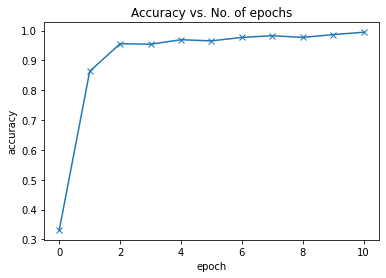

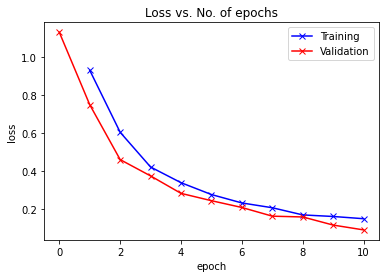

test result
{'val_loss': 0.09619417041540146, 'val_acc': 0.9913767576217651}


In [28]:
train_dl, val_dl, model = (train_loader, val_loader, model)
opt_func = torch.optim.Adam
  
  
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
plot_accuracies(history)
plot_losses(history)

print("test result")
print(evaluate(model, test_loader))

##FLOPs

In [29]:
 #The code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
  #Download the code.
!wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
!mv download FLOPs_counter.py
  #!rm -rf download

--2022-06-23 11:56:46--  https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
Resolving cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)... 202.158.207.20
Connecting to cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)|202.158.207.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: 5230042dc1897=jai3t52mkv3hbt2lhqlq63kck4; path=/plus;; Secure at position 53.
Syntax error in Set-Cookie: oc_sessionPassphrase=HumcG1GsgwnNb2WSk2AW5dUkL7Ntdik%2BDd6FKPsDoia7lLW1nkbqs6u%2FYBtizY%2FBZ5J%2BCQKHhj%2BRuRwkLkJe%2FNVVekEjjadW779q36PfvKv4w1sZlmQtSrRaktdScKR3; path=/plus;; Secure at position 174.
Length: 5201 (5.1K) [text/x-python]
Saving to: ‘download’

download            100%[===================>]   5.08K  --.-KB/s    in 0s      

2022-06-23 11:56:48 (592 MB/s) - ‘download’ saved [5201/5201]



In [30]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 40, 40) # The input size should be the same as the size that you put into your model 
#Get the network and its FLOPs
num_classes = 3
model = CnnModel(num_classes)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 1.14G


In [31]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CV_Competition/model.pth')